In [397]:
#: imports, nothing to see here
import random
from collections import defaultdict, namedtuple, deque
from itertools import product, starmap

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from matplotlib import animation
import copy


from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.normalization import BatchNormalization

from keras.optimizers import RMSprop


from numpy import sin, cos

%matplotlib inline

random.seed(1)

In [398]:
State = namedtuple('S', ['p', 'v'])
"""
dt = 0.01
mu = 0.5
goal_state = State(0, 11)
start_state = State(0, 0)

terminal = cliff_states + [goal_state]
dflt_reward = -1
cliff_reward = -100

a = {'<': -1, 'O': 0, '>': 1}

parameters = {'all_states': all_states,
              'cliff_states': cliff_states,
              'goal_state': goal_state,
              'start_state': start_state,
              'terminal': terminal,
              'dflt_reward': dflt_reward,
              'cliff_reward': cliff_reward,
              'moves': moves}
"""

"\ndt = 0.01\nmu = 0.5\ngoal_state = State(0, 11)\nstart_state = State(0, 0)\n\nterminal = cliff_states + [goal_state]\ndflt_reward = -1\ncliff_reward = -100\n\na = {'<': -1, 'O': 0, '>': 1}\n\nparameters = {'all_states': all_states,\n              'cliff_states': cliff_states,\n              'goal_state': goal_state,\n              'start_state': start_state,\n              'terminal': terminal,\n              'dflt_reward': dflt_reward,\n              'cliff_reward': cliff_reward,\n              'moves': moves}\n"

In [429]:
class MountainCar:
    def __init__(self):
        self._start_state = (random.uniform(-1.2, 0.5),
                             random.uniform(-0.07, 0.07))
        self._actions = [0, 1, -1]
        self.g = -0.0025
        self.log_state = []
        self.log_rewards = []
        self.rewards = 0

    def newstate(self, state, a):
        v_dot = (a ) * 0.001 + cos(3 * state.p) * (-0.0025)
        v_new = np.clip(state.v + v_dot, -0.07, 0.07)
        p_new = np.clip(state.p + v_new, -1.2, 0.6)
        if (p_new == -1.2 and v_new < 0):
            v_new = 0
        state_new = State(p=p_new, v=v_new)
        self.log_state.append(state_new)
        return state_new

    def is_terminal(self, state):
        if state.p >= 0.5:
            self.log_rewards.append(self.rewards)
            self.rewards = 0
            return True
        else:
            return False

    def reward(self, state):
        if state.p >= 0.5 :
            reward = 0
        else:
            reward = -1
        self.rewards+= reward
        return reward
    def compute_start_state(self):
        p = 0
        v = 0
        start_state = State(p=p, v=v)
        self.log_state.append(start_state)
        return start_state

In [437]:
def make_model():
    model = Sequential()
    rms = RMSprop()
    model.add(Dense(32, input_shape=(2,), init='zero', bias=True))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(64, init='zero', bias=True))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(64, init='zero', bias=True))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(3, init='zero',bias=True))
    model.add(BatchNormalization())
    model.add(Activation('linear'))
    model.compile(loss='mse', optimizer=rms)
    return model


class QAgent:
    def __init__(self,
                 env,
                 model,
                 alpha=0.001,
                 epsilon=1,
                 gamma=0.99,
                 buffer_size=300,
                 batch_size=32):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.reward_total = 0
        self.Q = make_model()
        self.buffer_size = buffer_size
        self.memory = deque(maxlen=1000)
        self.batch_size = batch_size
        self.actions = [-1, 0, 1]
        self.env = env
        self.log = []
        self.log_sum = []

    def act(self, state):
        if random.random() > self.epsilon:
            return self.greedy_action(state)
        else:
            return self.random_action(state)

    def make_batch(self):
        if len(self.memory)>= self.buffer_size:
            batch = random.sample(self.memory, self.batch_size)
            X_train = []
            y_train = []
            for state, action, newstate, reward in batch:
                s = np.asarray(state).reshape(1,2)
                X_train.append(s)
                y = self.Q.predict(s)[0]
                if reward == 0:
                    y[action] = reward
                    y_train.append(y)
                else:
                    ns = np.asarray(newstate).reshape(1,2)
                    Q_sa = np.max(self.Q.predict(ns)[0])
                    y[action] = reward + self.gamma * Q_sa
                    y_train.append(y)
            return np.vstack(X_train), np.vstack(y_train)

    def flashback(self):
        if len(self.memory)>= self.buffer_size:
            X, y = self.make_batch()
            loss = self.Q.fit(X, y, verbose=0)


    def random_action(self, state):
        choice = np.random.choice([-1,0,1])
        return choice

    def greedy_action(self, state):
        s = np.asarray(state).reshape(1,2)
        Qs = self.Q.predict(s)[0]
        action = np.argmax(Qs)
        return action

    def remember(self, state, action, newstate, reward):
        self.memory.append((state, action, newstate, reward))
        self.log.append((state[0], state[1]))
        if reward == 0:
            self.log_sum.append(self.log)
            self.log = []

    def save_net(self):
        self.Q.save('backup.h5')
        pass

In [438]:
def run_episode(domain, agent):
    state = domain.compute_start_state()
    step = 0
    while not domain.is_terminal(state):
        action = agent.act(state)    #: Take the current state as input and compute an action.
        newstate = domain.newstate(state, action)   #: Take the action and compute the changed state.
        reward = domain.reward(newstate)
        agent.remember(state, action, newstate, reward)#: Learn.
        agent.flashback()
        state = newstate                            #: Newstate becomes the current state for next iteration.
        step +=1
    print('WIN')
    print(step)
    pass

In [439]:
def run_random(domain, agent):
    state = domain.compute_start_state()
    step = 0
    while not domain.is_terminal(state):
        action = agent.act(state)    #: Take the current state as input and compute an action.
        newstate = domain.newstate(state, action)   #: Take the action and compute the changed state.
        reward = domain.reward(newstate)
        state = newstate                            #: Newstate becomes the current state for next iteration.
        step+=1
    pass


In [440]:
domain = MountainCar()
model = make_model()
agent = QAgent(domain, model)


In [441]:
def run_experiment(domain, agent, epsilon_decay, n_episodes):
    for i in range(5):
        run_random(domain, agent)
    agent.epsilon= 0.8
    print('Yo Random Ende')
    for i in range(n_episodes):
        agent.epsilon *= epsilon_decay
        run_episode(domain, agent)
        if i % 10==0:
            print(i)
    print('Setting epsilon paramter to zero',
          'to prevent random actions and evaluate learned policy.\n')
    agent.epsilon = 0
    run_episode(domain, agent)                    
    pass

In [442]:
n_episodes = 2000
epsilon_decay = 0.9

In [ ]:
run_experiment(domain, agent, epsilon_decay, n_episodes)

Yo Random Ende
WIN
373
0


In [72]:
x = np.arange(-1.5, 0.7, 0.001)
y = np.sin(3*x)
y_p = sin(3*p_i)*0.45
x_p



NameError: name 'x_p' is not defined

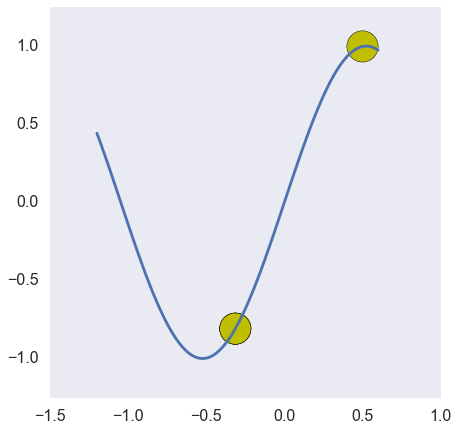

In [123]:
y_p = [ sin(3*x) for x in p_i]
fig = plt.figure()
fig.set_dpi(100)
fig.set_size_inches(7, 7)

ax = plt.axes(xlim=(-1.5, 0.5), ylim=(-2, 2))
x = np.linspace(-1.2, 0.6, 100)
y = np.sin(3*x)
ax.plot(x,y)
patch = plt.Circle((p_i[0], y_p[0]), 0.1, fc='y')
goal = plt.Circle((0.5, sin(3*0.5)), 0.1, fc='y')
ax.add_patch(patch)
ax.add_patch(goal)
plt.axis('equal')

def init():
    x = np.arange(-1.5, 0.7, 0.001)
    y = np.sin(3*x)*0.45
    patch.center = (p_i[0], y_p[0])
    ax.add_patch(patch)
    return patch,

def animate(i):
    patch.center = (p_i[i], y_p[i])
    return patch,

anim = animation.FuncAnimation(fig, animate, 
                               init_func=init, 
                               frames  =len(p_i), 
                               interval=1,
                               blit=True)

anim.save('animation.mp4', fps=30, 
          extra_args=['-vcodec', 'h264', 
                      '-pix_fmt', 'yuv420p'])



plt.show()

In [124]:
from IPython.display import HTML
h = \
"""
<video width="640" height="480" controls>
  <source src= "animation.ogv" type="video/ogg">
  <source src= "animation.mp4" type="video/mp4">
Your browser does not support the video tag, check out the YouTube version instead: http://youtu.be/SpgBHqW9om0
</video>
"""
HTML(h)

In [ ]:
def make_model():
    model = Sequential()
    rms = RMSprop()
    model.add(Dense(32, input_shape=(2,), init='zero', bias=True))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dense(64, init='zero', bias=True))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dense(3, init='zero',bias=True))
    model.add(BatchNormalization())
    model.add(Activation('linear'))
    model.compile(loss='mse', optimizer=rms)
    return model


class QAgent:
    def __init__(self,
                 env,
                 model,
                 alpha=0.001,
                 epsilon=0.99,
                 gamma=0.99,
                 buffer_size=100,
                 batch_size=16):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.reward_total = 0
        self.Q = make_model()
        self.buffer_size = buffer_size
        self.memory = deque(maxlen=10000000)
        self.actions = [-1, 0, 1]
        self.env = env
        self.log = []
        self.log_sum = []

    def act(self, state):
        if random.random() > self.epsilon:
            return self.greedy_action(state)
        else:
            return self.random_action(state)

    def make_batch(self):
        if len(self.memory)>= self.buffer_size:
            batch = random.sample(self.memory, self.batch_size)
            X_train = []
            y_train = []
            for state, action, newstate, reward in batch:
                s = np.asarray(state).reshape(1,2)
                X_train.append(s)
                y = self.Q.predict(s)[0]
                if reward == 0:
                    y[action] = reward
                    y_train.append(y)
                else:
                    ns = np.asarray(newstate).reshape(1,2)
                    Q_sa = np.max(self.Q.predict(ns)[0])
                    y[action] = reward + self.gamma * Q_sa
                    y_train.append(y)
            return np.vstack(X_train), np.vstack(y_train)

    def flashback(self):
        if len(self.memory)>= self.buffer_size:
            X, y = self.make_batch()
            loss = self.Q.fit(X, y, verbose=0)


    def random_action(self, state):
        choice = np.random.choice([-1,0,1])
        return choice

    def greedy_action(self, state):
        s = np.asarray(state).reshape(1,2)
        Qs = self.Q.predict(s)[0]
        action = np.argmax(Qs)
        return action

    def remember(self, state, action, newstate, reward):
        self.memory.append((state, action, newstate, reward))
        self.log.append((state[0], state[1]))
        if reward == 0:
            self.log_sum.append(self.log)
            self.log = []

    def save_net(self):
        self.Q.save('backup.h5')
        pass

In [15]:
env = MountainCar()

In [16]:
agent = QAgent